In [88]:
import os
import sys
import numpy as np
from os.path import join
from os.path import basename
from tqdm import tqdm
from tabulate import tabulate
from collections import Counter
from feature_analyzer.data_tools.embedding_container import EmbeddingContainer
from feature_analyzer.data_tools.result_container import ResultContainer

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
root_dir = '/home/kv_zhao/nist-e2e/feature-analyzer'
feat_dir = join(root_dir, 'examples')
resvar_dir = join(root_dir, 'results_variance')

In [3]:
ec1_name = 'featobj_mergeV1_iv3_D60kv2_noaug_CL003'
ec2_name = 'featobj_mergeV1_iv3_D60kv2_noaug_RM'
ec3_name = 'featobj_mergeV1_iv3_D60kv2_noaug_RMG_GS'
ec4_name = 'featobj_mergeV1_iv3_D60kv2_noaug_RMG2p_GS_final'
# embeddings
ec1 = EmbeddingContainer(name=ec1_name)
ec2 = EmbeddingContainer(name=ec2_name)
ec3 = EmbeddingContainer(name=ec3_name)
ec4 = EmbeddingContainer(name=ec4_name)
# results
rc1 = ResultContainer()
rc2 = ResultContainer()
rc3 = ResultContainer()
rc4 = ResultContainer()

Container:featobj_mergeV1_iv3_D60kv2_noaug_CL003 created
Container:featobj_mergeV1_iv3_D60kv2_noaug_RM created
Container:featobj_mergeV1_iv3_D60kv2_noaug_RMG_GS created
Container:featobj_mergeV1_iv3_D60kv2_noaug_RMG2p_GS_final created


In [14]:
namemap = {
    ec1_name: 'CL003',
    ec2_name: 'RM',
    ec3_name: 'RMG*',
    ec4_name: 'RMG2p*',
}

In [4]:
ec1.load(join(feat_dir, ec1_name))
ec2.load(join(feat_dir, ec2_name))
ec3.load(join(feat_dir, ec3_name))
ec4.load(join(feat_dir, ec4_name))

Load embedding container from feat_obj format
/home/kv_zhao/nist-e2e/feature-analyzer/examples/featobj_mergeV1_iv3_D60kv2_noaug_CL003/embeddings.npy is loaded
/home/kv_zhao/nist-e2e/feature-analyzer/examples/featobj_mergeV1_iv3_D60kv2_noaug_CL003/label_ids.npy is loaded
/home/kv_zhao/nist-e2e/feature-analyzer/examples/featobj_mergeV1_iv3_D60kv2_noaug_CL003/filename_strings.npy is loaded
/home/kv_zhao/nist-e2e/feature-analyzer/examples/featobj_mergeV1_iv3_D60kv2_noaug_CL003/probabilities.npy is loaded
/home/kv_zhao/nist-e2e/feature-analyzer/examples/featobj_mergeV1_iv3_D60kv2_noaug_CL003/label_names.npy is loaded
/home/kv_zhao/nist-e2e/feature-analyzer/examples/featobj_mergeV1_iv3_D60kv2_noaug_CL003/landmarks.npy is loaded
/home/kv_zhao/nist-e2e/feature-analyzer/examples/featobj_mergeV1_iv3_D60kv2_noaug_CL003/instance_ids.npy is loaded
container size: 10000 -> 134117
embedding size: 0 -> 512
probability size: 0 -> 1
landmark size: 0 -> 10
Reset featobj_mergeV1_iv3_D60kv2_noaug_CL003
Ind

In [5]:
rc1.load(join(resvar_dir, 'var_mergeV1_iv3_D60kv2_noaug_CL003'))
rc2.load(join(resvar_dir, 'var_mergeV1_iv3_D60kv2_noaug_RM'))
rc3.load(join(resvar_dir, 'var_mergeV1_iv3_D60kv2_noaug_RMG_GS'))
rc4.load(join(resvar_dir, 'var_mergeV1_iv3_D60kv2_noaug_RMG2p_GS_final'))

In [6]:
# Align three label_ids
def get_labelmap(container):
    inst_ids = container.instance_ids
    lids = container.get_label_by_instance_ids(inst_ids)
    lns = container.get_label_name_by_instance_ids(inst_ids)
    labelmap = {l: n for l, n in zip(lids, lns)}
    return labelmap

In [39]:
def get_class_attribute(container):
    inst_ids = container.instance_ids
    lids = container.get_label_by_instance_ids(inst_ids)
    lns = container.get_label_name_by_instance_ids(inst_ids)
    attrs = container.get_attribute_by_instance_ids(inst_ids)
    attrmap = {l: {
        'name': n['identity_name'],
        'src': n['source'],
    } for l, n in zip(lids, attrs)}
    return attrmap

In [7]:
ec1_labelmap = get_labelmap(ec1)
ec2_labelmap = get_labelmap(ec2)
ec3_labelmap = get_labelmap(ec3)
ec4_labelmap = get_labelmap(ec4)

In [8]:
ec1_labelmap == ec2_labelmap == ec3_labelmap == ec4_labelmap

True

In [78]:
labelmap = ec1_labelmap
num_total_classes = len(labelmap)
num_total_instances = len(ec1.instance_ids)
print(num_total_classes, num_total_instances)

7474 134117


In [40]:
attrmap = get_class_attribute(ec1)

In [18]:
def get_foundation(container, results, labelmap):
    events = results.events
    purity_events = events[events.topk_purity == 1.0]
    foundation_events = purity_events[purity_events.last_pos_sim >= 1.5]
    foundation_classes = []
    label_ids = list(map(int, foundation_events.label_id.unique()))
    num_instance_for_label_id = {
        label_id: len(container.get_instance_ids_by_label(label_id)) for label_id in label_ids}
    for label_id in label_ids:
        num_margin_event = len(foundation_events[foundation_events.label_id == label_id])
        if num_margin_event == num_instance_for_label_id[label_id]:
            foundation_classes.append(label_id)
    return foundation_events, foundation_classes

In [62]:
def get_t1(container, results, labelmap):
    events = results.events
    purity_events = events[events.topk_purity != 1.0]
    return purity_events[purity_events.last_pos_sim < 1.5]

In [20]:
m1_fd_events, m1_fd_classes = get_foundation(ec1, rc1, labelmap)
m2_fd_events, m2_fd_classes = get_foundation(ec2, rc2, labelmap)
m3_fd_events, m3_fd_classes = get_foundation(ec3, rc3, labelmap)
m4_fd_events, m4_fd_classes = get_foundation(ec4, rc4, labelmap)

In [24]:
headerlist = ['Model', '#of Foundation Events', '#of Founcation Classes']
tablelist = [
    [namemap[ec1_name], len(m1_fd_events), len(m1_fd_classes)],
    [namemap[ec2_name], len(m2_fd_events), len(m2_fd_classes)],
    [namemap[ec3_name], len(m3_fd_events), len(m3_fd_classes)],
    [namemap[ec4_name], len(m4_fd_events), len(m4_fd_classes)],
]
table = tabulate(tablelist, headerlist)
print(table)

Model      #of Foundation Events    #of Founcation Classes
-------  -----------------------  ------------------------
CL003                      82180                      4156
RM                         82809                      4218
RMG*                       86492                      4427
RMG2p*                     86910                      4463


In [25]:
common_fd_classes = list(
    set(m1_fd_classes) & set(m2_fd_classes) & set(m3_fd_classes) & set(m4_fd_classes))

In [44]:
common_fd_class_srcs = [
    attrmap[label]['src'] for label in common_fd_classes
]
print(Counter(common_fd_class_srcs) )

Counter({'CASIA': 1573, 'VGG': 889, '': 688, 'MS1M': 541})


In [59]:
m1m4_common_fd_classes = list(set(m1_fd_classes) & set(m4_fd_classes))
m1m4_common_fd_events = list(set(m1_fd_events.instance_id) & set(m4_fd_events.instance_id))
m2m4_common_fd_classes = list(set(m2_fd_classes) & set(m4_fd_classes))
m2m4_common_fd_events = list(set(m2_fd_events.instance_id) & set(m4_fd_events.instance_id))
m3m4_common_fd_classes = list(set(m3_fd_classes) & set(m4_fd_classes))
m3m4_common_fd_events = list(set(m3_fd_events.instance_id) & set(m4_fd_events.instance_id))

In [63]:
m1t1 = get_t1(ec1, rc1, labelmap)
m2t1 = get_t1(ec2, rc2, labelmap)
m3t1 = get_t1(ec3, rc3, labelmap)
m4t1 = get_t1(ec4, rc4, labelmap)

In [80]:
sim_ranges = [(1.5, 1.45), (1.45, 1.4), (1.4, 1.3), (1.3, 0.9)]
headerlist = ['Model', '[1.5, 1.45]', '[1.45, 1.4]', '[1.4, 1.3]', '[1.3, 0.9]']
tablelist = []
for name, events in zip([ec1_name, ec2_name, ec3_name, ec4_name], [m1t1, m2t1, m3t1, m4t1]):
    vals = [namemap[name]]
    for r in sim_ranges:
        sim_in_between= events[events.last_pos_sim.between(r[1], r[0])]
        vals.append('{}/{} ({:02.5f})'.format(len(sim_in_between), num_total_instances, len(sim_in_between) / num_total_instances))
    tablelist.append(vals)
table = tabulate(tablelist, headerlist)
print(table)

Model    [1.5, 1.45]           [1.45, 1.4]            [1.4, 1.3]             [1.3, 0.9]
-------  --------------------  ---------------------  ---------------------  ---------------------
CL003    373/134117 (0.00278)  1891/134117 (0.01410)  8584/134117 (0.06400)  9102/134117 (0.06787)
RM       324/134117 (0.00242)  1067/134117 (0.00796)  6672/134117 (0.04975)  9362/134117 (0.06980)
RMG*     224/134117 (0.00167)  928/134117 (0.00692)   5989/134117 (0.04466)  8872/134117 (0.06615)
RMG2p*   201/134117 (0.00150)  853/134117 (0.00636)   5577/134117 (0.04158)  8823/134117 (0.06579)


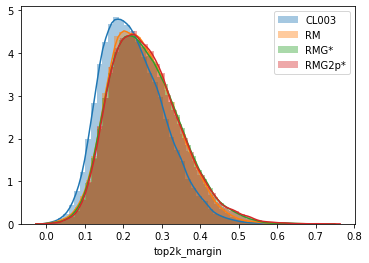

In [89]:
sns.distplot(m1_fd_events.top2k_margin)
sns.distplot(m2_fd_events.top2k_margin)
sns.distplot(m3_fd_events.top2k_margin)
sns.distplot(m4_fd_events.top2k_margin)
plt.legend(labels=[
    namemap[ec1_name],
    namemap[ec2_name],
    namemap[ec3_name],
    namemap[ec4_name],
])